# EK80 Data Processing Pipeline (v01)

**Broadband EK80 calibration sphere analysis using echopype**  
Emmett Culhane

This notebook processes a `.raw` file from a Simrad EK80 wideband transceiver
(ES120-18CDK-Split, 90–150 kHz FM chirp) recorded in the same CRL tank setup
as the EchoBot tests.  It serves as a reference/validation dataset for
comparison with the EchoBot pipeline (`echobot_pipeline_01`).

**File:** `prod-D20250904-T165452.raw`  
**Date:** 09/04/2025  
**Time:** 12:55 – 13:43 local (16:54 – 17:43 UTC)  
**Stationary targets:** 13:40+ local (17:40+ UTC)

In [1]:
import echopype as ep
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

# UTC -> local offset (TimeBias = 240 min = 4 h)
UTC_OFFSET = timedelta(hours=-4)

print(f'echopype {ep.__version__}')

echopype 0.11.0


## 1 — Load raw EK80 data

In [2]:
raw_file = '../../Data/prod-D20250904-T165452.raw'
ed = ep.open_raw(raw_file, sonar_model='EK80')

print(ed)
print(f"\nChannel: {ed['Sonar'].channel_all.values}")
print(f"Transducer: {ed['Sonar'].transducer_name.values}")
print(f"Nominal freq: {ed['Sonar'].frequency_nominal.values[0]/1e3:.0f} kHz")

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains complex backscatter data and other beam or channel-specific data.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

Channel: ['WBT Tube 277108-7 ES120-18CDK-Split_ES']
Transducer: ['ES120-18CDK-Split']
Nominal freq: 120 kHz


## 2 — Inspect metadata

In [3]:
beam = ed['Sonar/Beam_group1']
env  = ed['Environment']
vs   = ed['Vendor_specific']

ping_times = beam.ping_time.values
n_pings    = len(ping_times)
n_samples  = beam.dims['range_sample']
n_beams    = beam.dims['beam']

# Transmit parameters (from first ping)
f_start = float(beam['transmit_frequency_start'].values[0, 0])
f_stop  = float(beam['transmit_frequency_stop'].values[0, 0])
t_dur   = float(beam['transmit_duration_nominal'].values[0, 0])
fs_rx   = float(vs['receiver_sampling_frequency'].values[0])

# Calibration
gain = float(vs['gain_correction'].values[0, 0])
eba  = float(beam['equivalent_beam_angle'].values[0])
c_xd = float(env['transducer_sound_speed'].values[0])
c_sw = float(env['sound_speed_indicative'].values[0])

print(f'Pings:       {n_pings}')
print(f'Samples/ping: {n_samples}')
print(f'Beams:       {n_beams} (split-beam)')
print(f'Time (UTC):  {ping_times[0]}  →  {ping_times[-1]}')
print(f'FM sweep:    {f_start/1e3:.0f} – {f_stop/1e3:.0f} kHz')
print(f'Pulse dur:   {t_dur*1e3:.3f} ms')
print(f'Rx sample rate: {fs_rx/1e3:.0f} kHz')
print(f'Gain: {gain:.1f} dB,  EBA: {eba:.1f} dB')
print(f'Sound speed: {c_sw:.0f} m/s (water),  {c_xd:.0f} m/s (transducer)')

Pings:       2867
Samples/ping: 1257
Beams:       3 (split-beam)
Time (UTC):  2025-09-04T16:54:52.091518000  →  2025-09-04T17:43:06.091957000
FM sweep:    90 – 150 kHz
Pulse dur:   0.512 ms
Rx sample rate: 1500 kHz
Gain: 18.0 dB,  EBA: -12.5 dB
Sound speed: 1491 m/s (water),  1500 m/s (transducer)


## 3 — Compute broadband TS

echopype's `compute_TS` with `waveform_mode="BB"` handles pulse compression
(matched filtering with the chirp replica), TVG correction (40 log R), and
frequency-integrated calibration.  Output is TS in dB re 1 m².

In [4]:
ds_TS = ep.calibrate.compute_TS(ed, waveform_mode='BB', encode_mode='complex')

TS   = ds_TS['TS'].values[0, :, :]            # (n_pings, n_range)  already dB
r_ax = ds_TS['echo_range'].values[0, 0, :]    # range axis (m)

print(f'TS shape:  {TS.shape}')
print(f'Range:     {r_ax[0]:.3f} – {r_ax[-1]:.3f} m  ({len(r_ax)} bins)')
print(f'TS dtype:  {TS.dtype}  (values are dB re 1 m²)')

TS shape:  (2867, 1257)
Range:     0.000 – 9.991 m  (1257 bins)
TS dtype:  float64  (values are dB re 1 m²)


## 4 — Echogram (full record)

TS echogram over the full recording.  X-axis shows local time (UTC − 4 h).

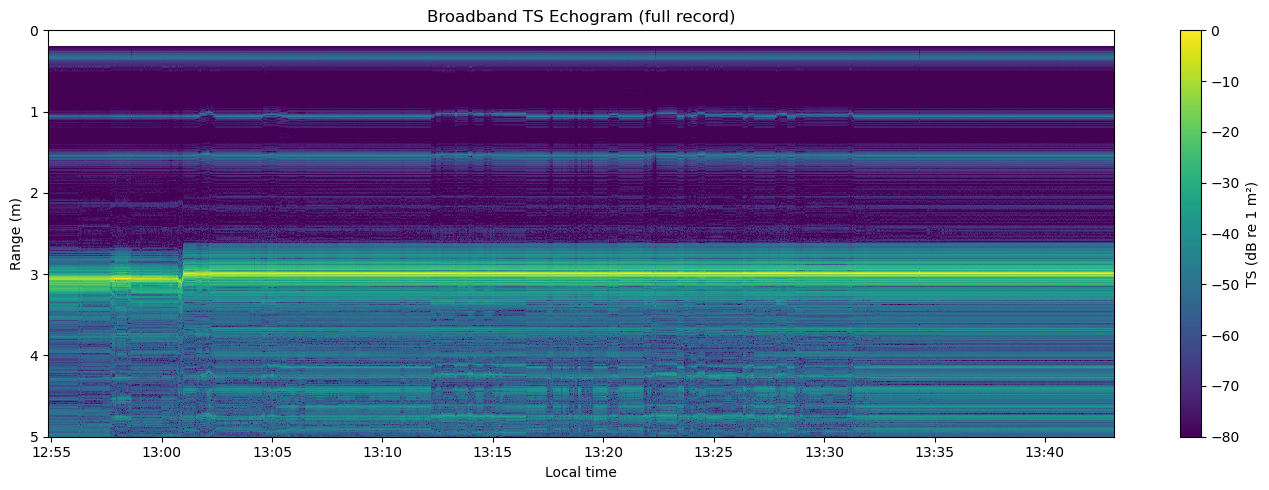

In [5]:
# Convert ping times to local
local_times = ping_times + np.timedelta64(int(UTC_OFFSET.total_seconds()), 's')

fig, ax = plt.subplots(figsize=(14, 5))
im = ax.pcolormesh(local_times, r_ax, TS.T,
                   vmin=-80, vmax=0, cmap='viridis', shading='auto')
ax.set_ylim([0, 5])
ax.invert_yaxis()
ax.set_ylabel('Range (m)')
ax.set_xlabel('Local time')
ax.set_title('Broadband TS Echogram (full record)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.colorbar(im, ax=ax, label='TS (dB re 1 m²)')
plt.tight_layout()
plt.show()

## 5 — Time-gate: stationary targets (13:40+ local)

Select only pings from 17:40 UTC onward, when targets were stationary.

Stationary pings: 187 of 2867
Time window (local): 2025-09-04T13:40:00.088402000 → 2025-09-04T13:43:06.091957000


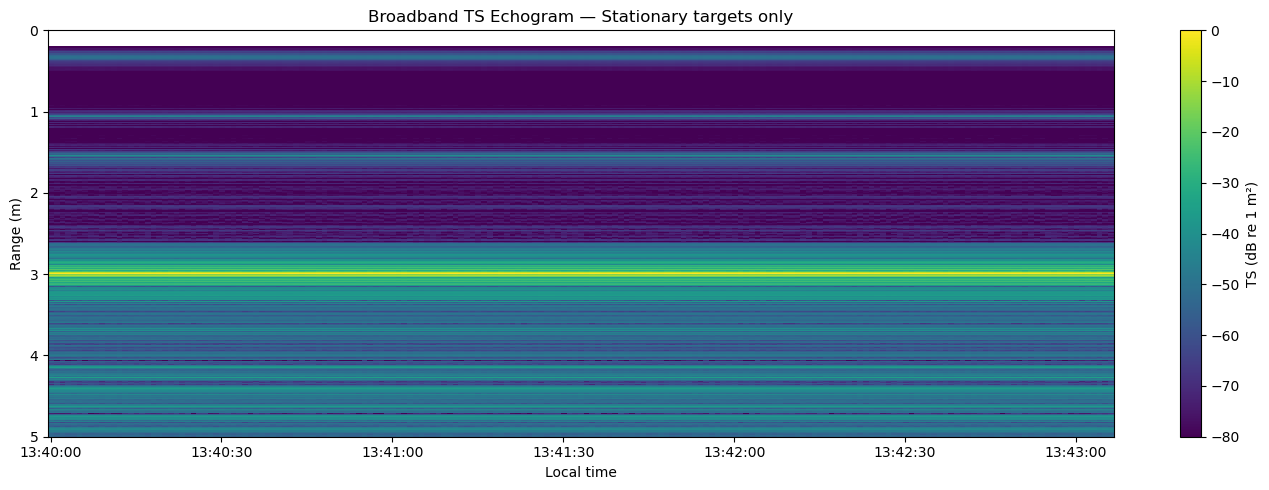

In [6]:
t_stationary = np.datetime64('2025-09-04T17:40:00')
stat_mask = ping_times >= t_stationary

TS_stat      = TS[stat_mask, :]
times_stat   = ping_times[stat_mask]
local_stat   = local_times[stat_mask]

print(f'Stationary pings: {stat_mask.sum()} of {n_pings}')
print(f'Time window (local): {local_stat[0]} → {local_stat[-1]}')

# Echogram — stationary period
fig, ax = plt.subplots(figsize=(14, 5))
im = ax.pcolormesh(local_stat, r_ax, TS_stat.T,
                   vmin=-80, vmax=0, cmap='viridis', shading='auto')
ax.set_ylim([0, 5])
ax.invert_yaxis()
ax.set_ylabel('Range (m)')
ax.set_xlabel('Local time')
ax.set_title('Broadband TS Echogram — Stationary targets only')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.colorbar(im, ax=ax, label='TS (dB re 1 m²)')
plt.tight_layout()
plt.show()

## 6 — Mean TS profiles & range window identification

Compute the mean TS profile (averaging in linear domain, converting back to dB)
for all pings and for the stationary period.  Identify target, noise, and floor
ranges from the stationary profile.

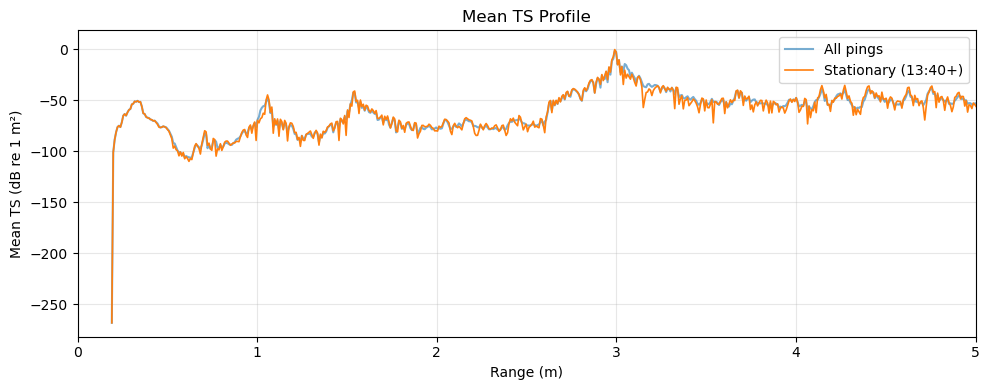

In [7]:
def mean_TS_dB(ts_dB_array, axis=0):
    """Average TS in the linear domain, return dB."""
    linear = 10 ** (ts_dB_array / 10)
    return 10 * np.log10(np.nanmean(linear, axis=axis))

ts_profile_all  = mean_TS_dB(TS,      axis=0)
ts_profile_stat = mean_TS_dB(TS_stat,  axis=0)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(r_ax, ts_profile_all,  label='All pings', alpha=0.6)
ax.plot(r_ax, ts_profile_stat, label='Stationary (13:40+)', linewidth=1.2)
ax.set_xlim([0, 5])
ax.set_xlabel('Range (m)')
ax.set_ylabel('Mean TS (dB re 1 m²)')
ax.set_title('Mean TS Profile')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7 — Define range windows

Identify:
- **Tank floor** — strongest return beyond 2.5 m
- **Target window** — region around the sphere echo (inspect profile above)
- **Noise window** — quiet region between transducer and target

Tank floor detected at 2.991 m
Target peak at 1.543 m

Target band:  [np.float64(1.293202444312244), np.float64(1.793202444312244)]
Noise band:   [0.4, 0.7000000000000001]


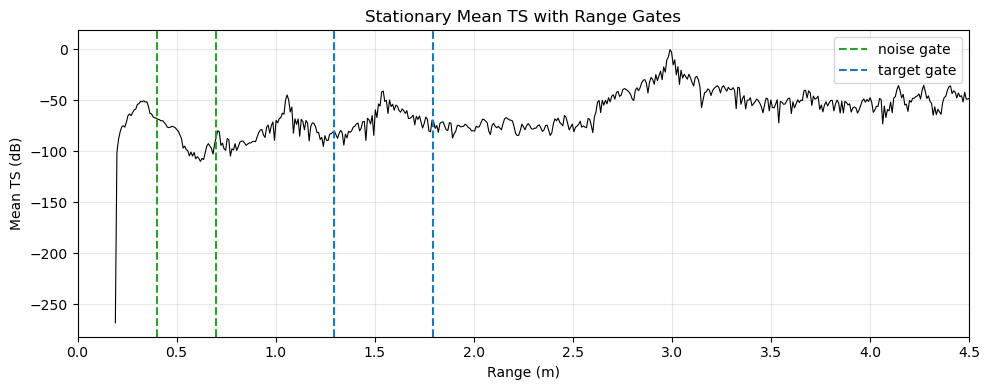

In [8]:
# ---- Tank floor: peak in stationary profile, 2.5–5.0 m ----
floor_mask = (r_ax > 2.5) & (r_ax < 5.0)
floor_idx = np.nanargmax(ts_profile_stat[floor_mask])
tank_floor_range = r_ax[floor_mask][floor_idx]
print(f'Tank floor detected at {tank_floor_range:.3f} m')

# ---- Target window: peak in 1.0–2.5 m range ----
target_search = (r_ax >= 1.0) & (r_ax <= 2.5)
target_peak_idx = np.nanargmax(ts_profile_stat[target_search])
target_peak_range = r_ax[target_search][target_peak_idx]
print(f'Target peak at {target_peak_range:.3f} m')

# Define windows
target_center = target_peak_range
target_half   = 0.25
target_band   = [target_center - target_half, target_center + target_half]

# Noise window: quiet region 0.3–0.8 m (above any target)
noise_center = 0.55
noise_half   = 0.15
noise_band   = [noise_center - noise_half, noise_center + noise_half]

print(f'\nTarget band:  {target_band}')
print(f'Noise band:   {noise_band}')

# ---- Plot with gates ----
CLR_NOISE  = '#2ca02c'
CLR_TARGET = '#1f77b4'

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(r_ax, ts_profile_stat, 'k', linewidth=0.8)
ax.axvline(noise_band[0],  color=CLR_NOISE,  ls='--', lw=1.5, label='noise gate')
ax.axvline(noise_band[1],  color=CLR_NOISE,  ls='--', lw=1.5)
ax.axvline(target_band[0], color=CLR_TARGET, ls='--', lw=1.5, label='target gate')
ax.axvline(target_band[1], color=CLR_TARGET, ls='--', lw=1.5)
ax.set_xlim([0, 4.5])
ax.set_xlabel('Range (m)')
ax.set_ylabel('Mean TS (dB)')
ax.set_title('Stationary Mean TS with Range Gates')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8 — Mean TS (broadband)

Compute the mean broadband TS within the target gate, for all pings
and for the stationary subset.

Mean broadband TS (all pings):        -42.4 dB
Mean broadband TS (stationary):       -40.9 dB
Std broadband TS  (stationary):       0.08 dB


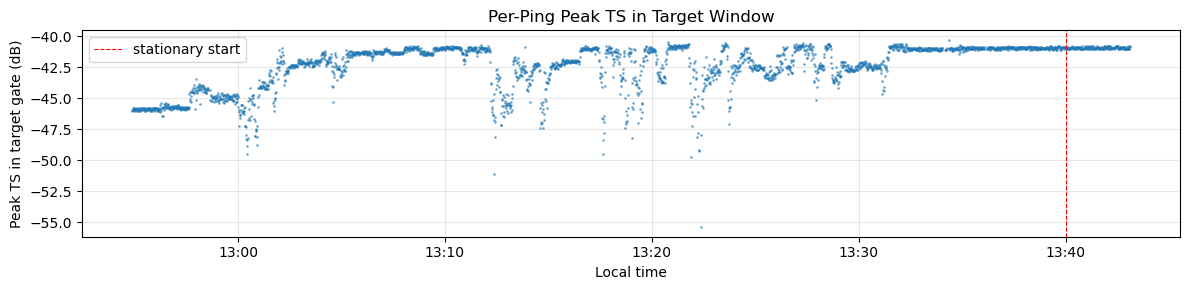

In [9]:
# Range indices for the target gate
j0t = np.searchsorted(r_ax, target_band[0])
j1t = np.searchsorted(r_ax, target_band[1], side='right')

# Per-ping peak TS in target gate
ts_target_all  = np.nanmax(TS[:, j0t:j1t], axis=1)
ts_target_stat = np.nanmax(TS_stat[:, j0t:j1t], axis=1)

print(f'Mean broadband TS (all pings):        {np.nanmean(ts_target_all):.1f} dB')
print(f'Mean broadband TS (stationary):       {np.nanmean(ts_target_stat):.1f} dB')
print(f'Std broadband TS  (stationary):       {np.nanstd(ts_target_stat):.2f} dB')

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(local_times, ts_target_all, '.', markersize=2, alpha=0.5)
ax.axvline(local_stat[0], color='r', ls='--', lw=0.8, label='stationary start')
ax.set_ylabel('Peak TS in target gate (dB)')
ax.set_xlabel('Local time')
ax.set_title('Per-Ping Peak TS in Target Window')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9 — TS(f) via pulse compression & spectral decomposition

To compute TS(f), we perform our own pulse compression matching echopype's
internal approach, then take the FFT of range-gated sections.

**Chirp replica construction** (critical for proper pulse compression):

1. Generate a **real RF cosine chirp** at the receiver sample rate (1500 kHz)
   with Hanning edge taper (controlled by the `slope` parameter from the raw file)
2. **Filter through the WBT decimation filter** (complex coefficients stored in
   the raw file) and decimate
3. **Filter through the PC decimation filter** and decimate again
4. The result is a complex baseband chirp that matches the stored I/Q data

**Pulse compression**: time-domain convolution of the complex backscatter with
`flipud(conj(filtered_chirp))` — this is cross-correlation, equivalent to
matched filtering. Normalized by `||chirp||²`.

**TS(f)**: FFT of range-gated PC output (with Hanning window), then divided by
the chirp power spectrum `|TX(f)|²` to deconvolve the chirp's spectral shape
and recover the target's transfer function H(f).

RF chirp:       767 samples at 1500 kHz
WBT filter:     47 taps, ×8 decimation
PC filter:      91 taps, ×2 decimation
Filtered chirp: 96 complex samples at 93.75 kHz
Sweep:          90 → 150 kHz  (center 120)
Taper slope:    0.0434028
In-band bins:   3670 of 4096
Freq range:     81.0 – 165.0 kHz


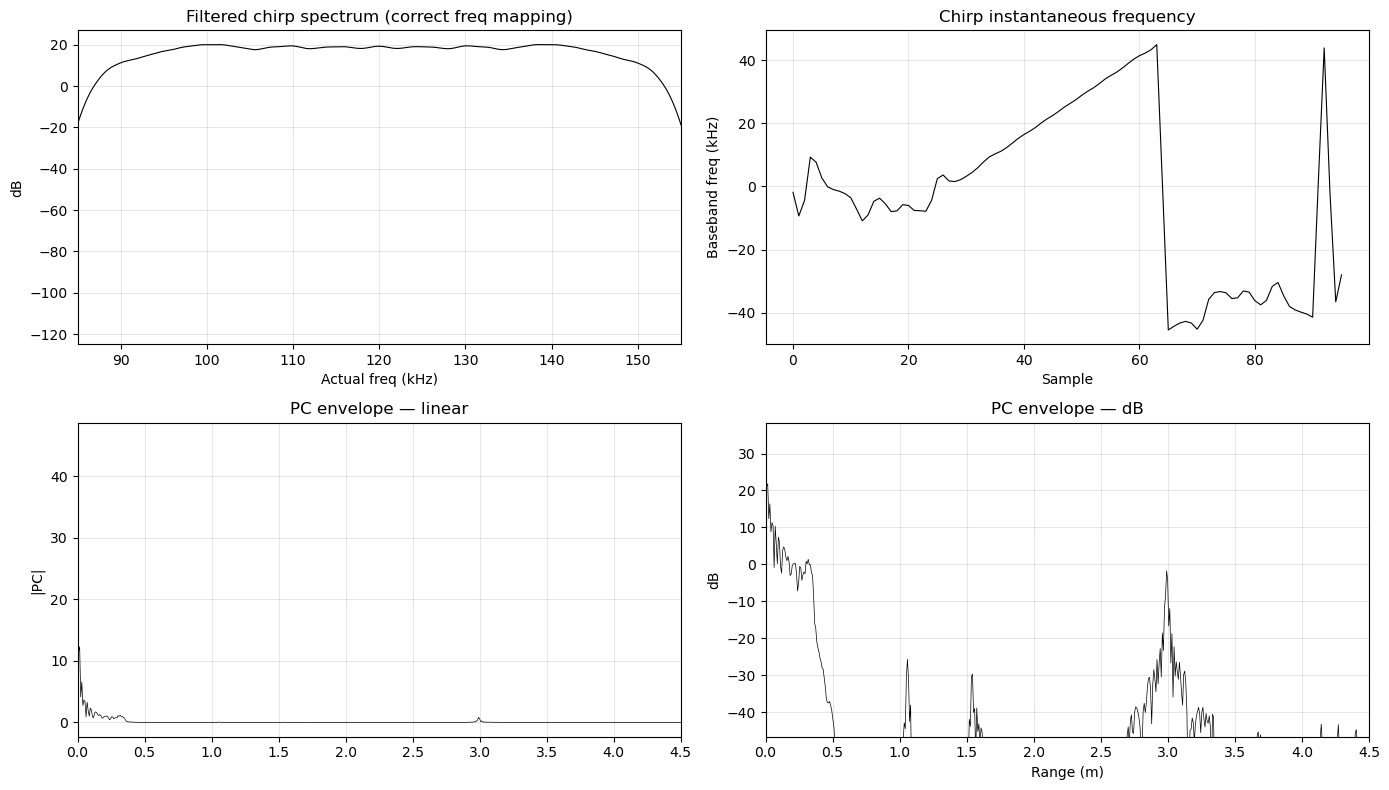

In [10]:
from scipy.signal import convolve as sig_convolve
from echopype.calibrate.ek80_complex import get_filter_coeff

# ---- Extract transmit parameters ----
beam_ds = ed['Sonar/Beam_group1']
vs      = ed['Vendor_specific']

sample_int = float(beam_ds['sample_interval'].values[0, 0])
fs_eff     = 1.0 / sample_int
f_start    = float(beam_ds['transmit_frequency_start'].values[0, 0])
f_stop     = float(beam_ds['transmit_frequency_stop'].values[0, 0])
t_dur      = float(beam_ds['transmit_duration_nominal'].values[0, 0])
slope_val  = float(beam_ds['slope'].values[0, 0])
fs_rx      = float(vs['receiver_sampling_frequency'].values[0])
f_center   = (f_start + f_stop) / 2
c_sw       = float(ed['Environment']['sound_speed_indicative'].values[0])

# ==================================================================
# Step 1:  Real RF chirp with Hanning edge taper
# ==================================================================
n_rf = int(np.floor(t_dur * fs_rx))
t_rf = np.arange(n_rf) / fs_rx
y_rf = np.cos(np.pi * (f_stop - f_start) / t_dur * t_rf**2
              + 2 * np.pi * f_start * t_rf)

L_taper = int(np.round(t_dur * fs_rx * slope_val * 2.0))
if L_taper > 1:
    w = 0.5 * (1 - np.cos(2 * np.pi * np.arange(L_taper) / (L_taper - 1)))
    w1 = w[:L_taper // 2]
    w2 = w[L_taper // 2 : -1]
    y_rf[:len(w1)] *= w1
    if len(w2) > 0:
        y_rf[-len(w2):] *= w2
y_rf /= np.max(np.abs(y_rf))

# ==================================================================
# Step 2:  Extract WBT & PC filter coefficients
# ==================================================================
coeff   = get_filter_coeff(vs)
ch_id   = list(coeff.keys())[0]
wbt_fil = coeff[ch_id]['wbt_fil']
pc_fil  = coeff[ch_id]['pc_fil']
wbt_dec = int(coeff[ch_id]['wbt_decifac'])
pc_dec  = int(coeff[ch_id]['pc_decifac'])

# ==================================================================
# Step 3:  Filter & decimate chirp through WBT → PC chain
# ==================================================================
ytx_wbt     = sig_convolve(y_rf, wbt_fil)
ytx_wbt_dec = ytx_wbt[::wbt_dec]
ytx_pc      = sig_convolve(ytx_wbt_dec, pc_fil)
tx_filtered = ytx_pc[::pc_dec]

norm_fac   = np.linalg.norm(tx_filtered) ** 2
mf_replica = np.flipud(np.conj(tx_filtered))

# ---- Range axis ----
r_raw = np.arange(n_samples) * sample_int * c_sw / 2

# ==================================================================
# Step 4:  Aliasing-aware frequency mapping
#
# The decimation (fs_rx → fs_eff) causes the chirp band [90–150 kHz]
# to alias into non-contiguous baseband segments.  For each FFT bin
# at baseband freq f_bb, the correct actual freq is:
#   f_actual = f_bb + k·fs_eff   where k chosen so f_actual ∈ [f_start, f_stop]
# ==================================================================
Nfft = 4096
f_bb_fft = np.fft.fftfreq(Nfft, d=1.0 / fs_eff)   # FFT-order (NOT shifted)

f_actual_map = np.full(Nfft, np.nan)
for i, fb in enumerate(f_bb_fft):
    for k in range(-10, 11):
        f_try = fb + k * fs_eff
        if f_start * 0.90 <= f_try <= f_stop * 1.10:
            f_actual_map[i] = f_try
            break

# In-band indices, sorted by actual frequency
band_idx = np.where(~np.isnan(f_actual_map))[0]
sort_order = np.argsort(f_actual_map[band_idx])
band_idx_sorted = band_idx[sort_order]
f_band_sorted = f_actual_map[band_idx_sorted]          # actual-frequency axis

# Chirp power spectrum at in-band bins (for deconvolution)
TX_fft = np.fft.fft(tx_filtered, n=Nfft)
TX_power_band = np.abs(TX_fft[band_idx_sorted]) ** 2
TX_power_band = np.maximum(TX_power_band, np.max(TX_power_band) * 1e-10)

# Tighter band mask for plots (skip bins right at the very edges)
plot_mask = (f_band_sorted >= f_start * 0.97) & (f_band_sorted <= f_stop * 1.03)

# ---- Print summary ----
print(f'RF chirp:       {n_rf} samples at {fs_rx/1e3:.0f} kHz')
print(f'WBT filter:     {len(wbt_fil)} taps, ×{wbt_dec} decimation')
print(f'PC filter:      {len(pc_fil)} taps, ×{pc_dec} decimation')
print(f'Filtered chirp: {len(tx_filtered)} complex samples at {fs_eff/1e3:.2f} kHz')
print(f'Sweep:          {f_start/1e3:.0f} → {f_stop/1e3:.0f} kHz  (center {f_center/1e3:.0f})')
print(f'Taper slope:    {slope_val}')
print(f'In-band bins:   {len(band_idx_sorted)} of {Nfft}')
print(f'Freq range:     {f_band_sorted[0]/1e3:.1f} – {f_band_sorted[-1]/1e3:.1f} kHz')

# ==================================================================
# Diagnostic: chirp spectrum + PC envelope
# ==================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Top-left: chirp spectrum at actual frequencies
TX_mag_dB = 20 * np.log10(np.abs(TX_fft[band_idx_sorted]) + 1e-30)
axes[0, 0].plot(f_band_sorted / 1e3, TX_mag_dB, 'k', lw=0.8)
axes[0, 0].set_xlabel('Actual freq (kHz)'); axes[0, 0].set_ylabel('dB')
axes[0, 0].set_title('Filtered chirp spectrum (correct freq mapping)')
axes[0, 0].set_xlim([85, 155]); axes[0, 0].grid(True, alpha=0.3)

# Top-right: chirp instantaneous frequency
_phase = np.unwrap(np.angle(tx_filtered))
_f_inst = np.gradient(_phase) * fs_eff / (2 * np.pi)
axes[0, 1].plot(_f_inst / 1e3, 'k', lw=0.8)
axes[0, 1].set_xlabel('Sample'); axes[0, 1].set_ylabel('Baseband freq (kHz)')
axes[0, 1].set_title('Chirp instantaneous frequency')
axes[0, 1].grid(True, alpha=0.3)

# Bottom: PC envelope (linear + dB) for one stationary ping
_tidx = np.where(ping_times >= np.datetime64('2025-09-04T17:40:00'))[0]
_test = _tidx[len(_tidx) // 2]
_raw  = (beam_ds['backscatter_r'].values[0, _test, :, :]
       + 1j * beam_ds['backscatter_i'].values[0, _test, :, :]).mean(axis=1)
_pc   = sig_convolve(_raw, mf_replica, mode='full')[len(mf_replica)-1:][:n_samples]
_pc  /= norm_fac

axes[1, 0].plot(r_raw, np.abs(_pc), 'k', lw=0.5)
axes[1, 0].set_xlim([0, 4.5]); axes[1, 0].set_ylabel('|PC|')
axes[1, 0].set_title('PC envelope — linear'); axes[1, 0].grid(True, alpha=0.3)

_pc_dB = 20 * np.log10(np.abs(_pc) + 1e-30)
axes[1, 1].plot(r_raw, _pc_dB, 'k', lw=0.5)
axes[1, 1].set_xlim([0, 4.5])
axes[1, 1].set_ylim([np.max(_pc_dB) - 80, np.max(_pc_dB) + 5])
axes[1, 1].set_xlabel('Range (m)'); axes[1, 1].set_ylabel('dB')
axes[1, 1].set_title('PC envelope — dB'); axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
def process_ping_pc(ed, ping_idx, beam_idx=None):
    """
    Pulse compression for one ping, matching echopype's approach:
    convolve(data, flipud(conj(filtered_chirp))), normalized by ||chirp||².
    """
    _b = ed['Sonar/Beam_group1']
    raw = (_b['backscatter_r'].values[0, ping_idx, :, :]
         + 1j * _b['backscatter_i'].values[0, ping_idx, :, :])
    raw_sig = raw[:, beam_idx] if beam_idx is not None else raw.mean(axis=1)
    pc = sig_convolve(raw_sig, mf_replica, mode='full')[len(mf_replica)-1:][:n_samples]
    return pc / norm_fac


def compute_tsf(pc_signal, r_axis, gate_band, nfft=4096):
    """FFT of range-gated PC output with Hanning window."""
    j0 = np.searchsorted(r_axis, gate_band[0])
    j1 = np.searchsorted(r_axis, gate_band[1], side='right')
    gated = pc_signal[j0:j1]
    if len(gated) > 1:
        gated = gated * np.hanning(len(gated))
    return np.fft.fft(gated, n=nfft)


# ---- Calibration parameters (matching echopype's _cal_complex_samples) ----
# echopype TS formula:
#   prx = n_beam * |mean_beam(pc)|^2 / (2*sqrt(2))^2 * (|z_er+z_et|/z_er)^2 / z_et
#   TS  = 10*log10(prx) + 40*log10(R) + 2*alpha*R
#         - 10*log10(lambda^2 * Ptx / (16*pi^2)) - 2*gain
#
# Our pc is already mean_beam (or single beam) and normalized by norm_fac.
# For TS(f), we apply the same calibration to the spectral decomposition.

Ptx    = float(beam_ds['transmit_power'].values[0, 0])       # transmit power (W)
z_er   = float(vs['impedance_transceiver'].values[0].item())      # 10800 ohm
z_et   = 75.0                                              # transducer impedance (echopype default)
alpha_dBm = 0.04                                           # absorption ~0.04 dB/m at 120 kHz freshwater

# Impedance + scaling factor (in dB, constant for all frequencies)
#   prx_factor = n_beams * |pc|^2 / 8 * (|z_er+z_et|/z_er)^2 / z_et
# Since our pc = mean_beam(data) convolved / norm_fac, we need:
#   10*log10(prx) = 10*log10(n_beams/8 * (|z_er+z_et|/z_er)^2 / z_et) + 10*log10(|pc|^2)
# But for the spectral version, 10*log10(|pc|^2) is replaced by the deconvolved spectrum.
impedance_factor_dB = (10 * np.log10(n_beams / 8)
                       + 20 * np.log10(np.abs(z_er + z_et) / z_er)
                       - 10 * np.log10(z_et))

print(f'Calibration parameters:')
print(f'  Transmit power:  {Ptx:.0f} W')
print(f'  Z_transceiver:   {z_er:.0f} ohm')
print(f'  Z_transducer:    {z_et:.0f} ohm (default)')
print(f'  Impedance factor: {impedance_factor_dB:.2f} dB')
print(f'  Gain:            {gain:.1f} dB (2-way: {2*gain:.1f} dB)')
print(f'  norm_fac:        {norm_fac:.4e} (20*log10 = {20*np.log10(norm_fac):.1f} dB)')


def compute_absolute_tsf(spec_raw, R_center):
    """
    Compute absolute TS(f) in dB re 1 m² from FFT of gated PC output.

    Matches echopype's TS equation:
      TS = 10*log10(prx) + 40*log10(R) + 2*α*R
           - 10*log10(λ²*Ptx/(16π²)) - 2*gain

    Our PC output is normalized by norm_fac. The gated FFT gives the spectral
    content. Deconvolution by |TX(f)|² recovers the target transfer function.
    """
    # Deconvolved spectrum: H = Spec / |TX|^2
    H = spec_raw[band_idx_sorted] / TX_power_band

    # Raw deconvolved power (still missing calibration)
    # |H|^2 is proportional to the received power spectral density
    H_dB = 10 * np.log10(np.abs(H)**2 + 1e-30)

    # Undo PC normalization (our process_ping_pc divides by norm_fac)
    H_dB += 20 * np.log10(norm_fac)

    # Impedance + beam scaling (matching echopype's prx formula)
    H_dB += impedance_factor_dB

    # TVG: 40*log10(R)
    H_dB += 40 * np.log10(np.maximum(R_center, 0.01))

    # Absorption: 2*alpha*R
    H_dB += 2 * alpha_dBm * R_center

    # Sonar equation term: -10*log10(lambda^2 * Ptx / (16*pi^2))
    lam_f = c_sw / f_band_sorted
    H_dB -= 10 * np.log10(lam_f**2 * Ptx / (16 * np.pi**2))

    # Gain correction: -2*G
    H_dB -= 2 * gain

    return H_dB


# ---- Verification: compare band-averaged TS(f) with echopype broadband TS ----
_stat_pings = np.where(ping_times >= np.datetime64('2025-09-04T17:40:00'))[0]
_test_idx = _stat_pings[len(_stat_pings) // 2]

_pc_test = process_ping_pc(ed, _test_idx)
_spec_test = compute_tsf(_pc_test, r_raw, target_band, Nfft)
_tsf_abs = compute_absolute_tsf(_spec_test, target_peak_range)

# Band average in linear domain
_tsf_lin = 10 ** (_tsf_abs[plot_mask] / 10)
_tsf_band_avg = 10 * np.log10(np.mean(_tsf_lin))

# echopype broadband TS for same ping
_j0 = np.searchsorted(r_ax, target_band[0])
_j1 = np.searchsorted(r_ax, target_band[1], side='right')
_ts_echopype = np.nanmax(TS[_test_idx, _j0:_j1])

print(f'\nVerification (single stationary ping #{_test_idx}):')
print(f'  Band-averaged TS(f):  {_tsf_band_avg:.1f} dB')
print(f'  echopype broadband TS: {_ts_echopype:.1f} dB')
print(f'  Difference:           {_tsf_band_avg - _ts_echopype:.1f} dB')

print('\nHelper functions defined.')

Calibration parameters:
  Transmit power:  60 W
  Z_transceiver:   10800 ohm
  Z_transducer:    75 ohm (default)
  Impedance factor: -22.95 dB
  Gain:            18.0 dB (2-way: 36.0 dB)
  norm_fac:        4.4237e+01 (20*log10 = 32.9 dB)

Verification (single stationary ping #2773):
  Band-averaged TS(f):  -34.3 dB
  echopype broadband TS: -41.0 dB
  Difference:           6.7 dB

Helper functions defined.


## 10 — TS(f): all pings (averaged)

Average the TS(f) spectral magnitude across all pings to get the overall
target frequency response.

Averaged 2867 pings
Target TS(f) at 120 kHz: -43.6 dB


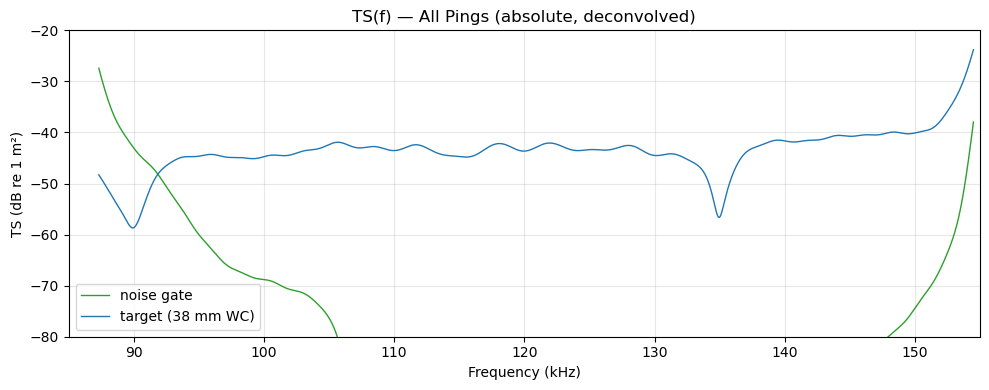

In [12]:
# Accumulate spectra across all pings
spec_target_acc = np.zeros(Nfft, dtype=complex)
spec_noise_acc  = np.zeros(Nfft, dtype=complex)
n_valid = 0

for p in range(n_pings):
    pc = process_ping_pc(ed, p)
    spec_target_acc += compute_tsf(pc, r_raw, target_band, Nfft)
    spec_noise_acc  += compute_tsf(pc, r_raw, noise_band,  Nfft)
    n_valid += 1

spec_target_avg = spec_target_acc / n_valid
spec_noise_avg  = spec_noise_acc  / n_valid

# Absolute TS(f) calibration
R_target_center = np.mean(target_band)
R_noise_center  = np.mean(noise_band)
TSf_target_all = compute_absolute_tsf(spec_target_avg, R_target_center)
TSf_noise_all  = compute_absolute_tsf(spec_noise_avg,  R_noise_center)

print(f'Averaged {n_valid} pings')
print(f'Target TS(f) at 120 kHz: {TSf_target_all[plot_mask][np.argmin(np.abs(f_band_sorted[plot_mask]-120e3))]:.1f} dB')

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(f_band_sorted[plot_mask] / 1e3, TSf_noise_all[plot_mask],
        color=CLR_NOISE, linewidth=1, label='noise gate')
ax.plot(f_band_sorted[plot_mask] / 1e3, TSf_target_all[plot_mask],
        color=CLR_TARGET, linewidth=1, label='target (38 mm WC)')
ax.set_xlim([f_start / 1e3 - 5, f_stop / 1e3 + 5])
ax.set_ylim([-80, -20])
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('TS (dB re 1 m²)')
ax.set_title('TS(f) — All Pings (absolute, deconvolved)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11 — TS(f): stationary targets only (13:40+ local)

Same processing but restricted to the stationary-target period.

Averaged 187 stationary pings
Stationary TS(f) at 120 kHz: -37.4 dB


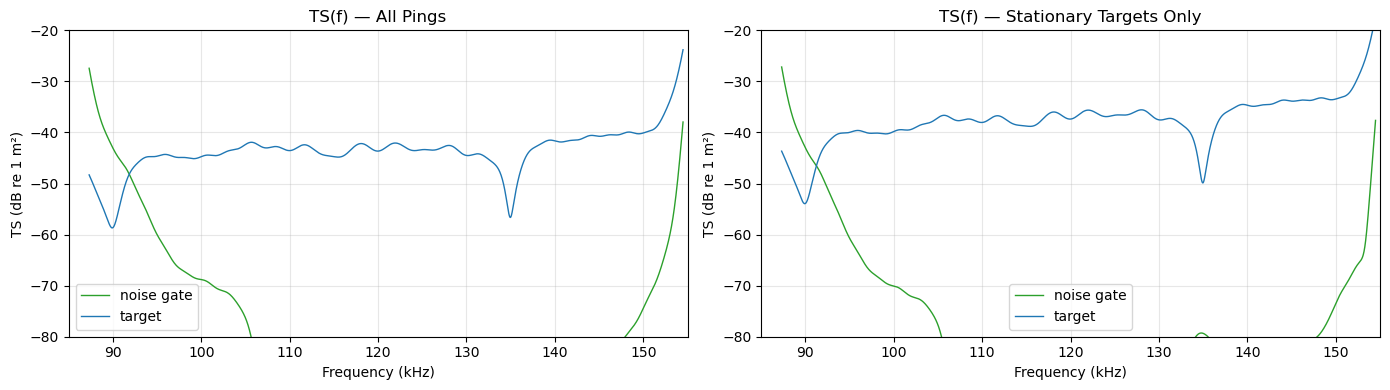

In [13]:
stat_indices = np.where(stat_mask)[0]

spec_target_st = np.zeros(Nfft, dtype=complex)
spec_noise_st  = np.zeros(Nfft, dtype=complex)
n_stat = 0

for p in stat_indices:
    pc = process_ping_pc(ed, p)
    spec_target_st += compute_tsf(pc, r_raw, target_band, Nfft)
    spec_noise_st  += compute_tsf(pc, r_raw, noise_band,  Nfft)
    n_stat += 1

spec_target_st_avg = spec_target_st / n_stat
spec_noise_st_avg  = spec_noise_st  / n_stat

# Absolute TS(f)
TSf_target_st = compute_absolute_tsf(spec_target_st_avg, R_target_center)
TSf_noise_st  = compute_absolute_tsf(spec_noise_st_avg,  R_noise_center)

# Recompute all-pings (already computed in cell 22, but redone for clarity)
TSf_target_all = compute_absolute_tsf(spec_target_avg, R_target_center)
TSf_noise_all  = compute_absolute_tsf(spec_noise_avg,  R_noise_center)

print(f'Averaged {n_stat} stationary pings')
print(f'Stationary TS(f) at 120 kHz: {TSf_target_st[plot_mask][np.argmin(np.abs(f_band_sorted[plot_mask]-120e3))]:.1f} dB')

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: all pings
axes[0].plot(f_band_sorted[plot_mask] / 1e3, TSf_noise_all[plot_mask],
             color=CLR_NOISE, linewidth=1, label='noise gate')
axes[0].plot(f_band_sorted[plot_mask] / 1e3, TSf_target_all[plot_mask],
             color=CLR_TARGET, linewidth=1, label='target')
axes[0].set_xlim([f_start / 1e3 - 5, f_stop / 1e3 + 5])
axes[0].set_ylim([-80, -20])
axes[0].set_xlabel('Frequency (kHz)')
axes[0].set_ylabel('TS (dB re 1 m²)')
axes[0].set_title('TS(f) — All Pings')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: stationary only
axes[1].plot(f_band_sorted[plot_mask] / 1e3, TSf_noise_st[plot_mask],
             color=CLR_NOISE, linewidth=1, label='noise gate')
axes[1].plot(f_band_sorted[plot_mask] / 1e3, TSf_target_st[plot_mask],
             color=CLR_TARGET, linewidth=1, label='target')
axes[1].set_xlim([f_start / 1e3 - 5, f_stop / 1e3 + 5])
axes[1].set_ylim([-80, -20])
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('TS (dB re 1 m²)')
axes[1].set_title('TS(f) — Stationary Targets Only')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12 — TS(f) per beam

Compute TS(f) for each of the 3 split-beam sectors individually
(stationary period), analogous to the per-sector plots in `echobot_pipeline_01`.

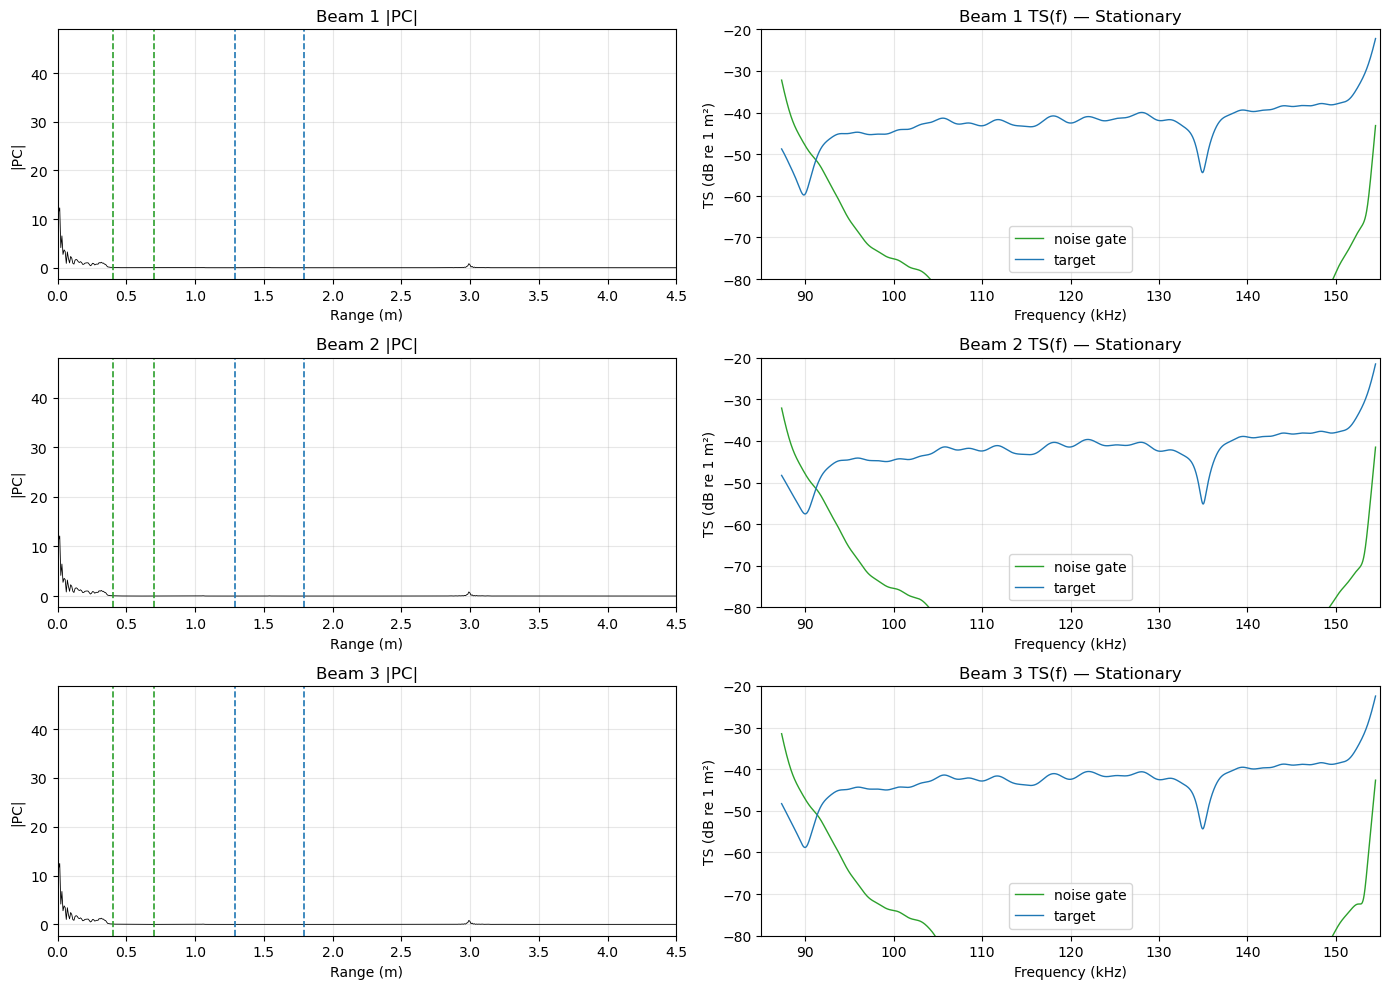

In [14]:
# Per-beam impedance factor (single beam: n_beam=1 instead of 3)
impedance_factor_per_beam_dB = (10 * np.log10(1 / 8)
                                + 20 * np.log10(np.abs(z_er + z_et) / z_er)
                                - 10 * np.log10(z_et))

def compute_absolute_tsf_per_beam(spec_raw, R_center):
    """Same as compute_absolute_tsf but with single-beam impedance factor."""
    H = spec_raw[band_idx_sorted] / TX_power_band
    H_dB = 10 * np.log10(np.abs(H)**2 + 1e-30)
    H_dB += 20 * np.log10(norm_fac)
    H_dB += impedance_factor_per_beam_dB
    H_dB += 40 * np.log10(np.maximum(R_center, 0.01))
    H_dB += 2 * alpha_dBm * R_center
    lam_f = c_sw / f_band_sorted
    H_dB -= 10 * np.log10(lam_f**2 * Ptx / (16 * np.pi**2))
    H_dB -= 2 * gain
    return H_dB

# Accumulate per-beam spectra over stationary pings
spec_t_beams = [np.zeros(Nfft, dtype=complex) for _ in range(n_beams)]
spec_n_beams = [np.zeros(Nfft, dtype=complex) for _ in range(n_beams)]

for p in stat_indices:
    for b in range(n_beams):
        pc_b = process_ping_pc(ed, p, beam_idx=b)
        spec_t_beams[b] += compute_tsf(pc_b, r_raw, target_band, Nfft)
        spec_n_beams[b] += compute_tsf(pc_b, r_raw, noise_band,  Nfft)

fig, axes = plt.subplots(n_beams, 2, figsize=(14, 10))

for b in range(n_beams):
    st_avg = spec_t_beams[b] / n_stat
    sn_avg = spec_n_beams[b] / n_stat

    # Absolute TS(f) per beam
    sdB_t = compute_absolute_tsf_per_beam(st_avg, R_target_center)
    sdB_n = compute_absolute_tsf_per_beam(sn_avg, R_noise_center)

    # Left: PC envelope for this beam (single ping illustration)
    pc_ex = process_ping_pc(ed, stat_indices[len(stat_indices)//2], beam_idx=b)
    ax_l = axes[b, 0]
    ax_l.plot(r_raw, np.abs(pc_ex), 'k', linewidth=0.6)
    ax_l.axvline(noise_band[0],  color=CLR_NOISE,  ls='--', lw=1.2)
    ax_l.axvline(noise_band[1],  color=CLR_NOISE,  ls='--', lw=1.2)
    ax_l.axvline(target_band[0], color=CLR_TARGET, ls='--', lw=1.2)
    ax_l.axvline(target_band[1], color=CLR_TARGET, ls='--', lw=1.2)
    ax_l.set_xlim([0, 4.5])
    ax_l.grid(True, alpha=0.3)
    ax_l.set_title(f'Beam {b+1} |PC|')
    ax_l.set_xlabel('Range (m)')
    ax_l.set_ylabel('|PC|')

    # Right: absolute TS(f)
    ax_r = axes[b, 1]
    ax_r.plot(f_band_sorted[plot_mask] / 1e3, sdB_n[plot_mask],
              linewidth=1, color=CLR_NOISE, label='noise gate')
    ax_r.plot(f_band_sorted[plot_mask] / 1e3, sdB_t[plot_mask],
              linewidth=1, color=CLR_TARGET, label='target')
    ax_r.set_xlim([f_start / 1e3 - 5, f_stop / 1e3 + 5])
    ax_r.set_ylim([-80, -20])
    ax_r.set_xlabel('Frequency (kHz)')
    ax_r.set_ylabel('TS (dB re 1 m²)')
    ax_r.set_title(f'Beam {b+1} TS(f) — Stationary')
    ax_r.legend(loc='best')
    ax_r.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13 — SNR (from calibrated TS)

Per-ping signal-to-noise ratio computed from echopype's calibrated TS values:

$$\mathrm{SNR_{dB}} = \mathrm{TS_{target\,peak}} - \mathrm{TS_{noise\,mean}}$$

The noise gate is placed between the sphere (~1.5 m) and tank floor (~3 m)
at 2.0–2.5 m, avoiding near-field transducer effects.

SNR noise gate: 2.0 – 2.5 m
SNR (all pings)  — mean: 30.9 dB,  std: 1.44 dB
SNR (stationary) — mean: 31.7 dB,  std: 0.14 dB


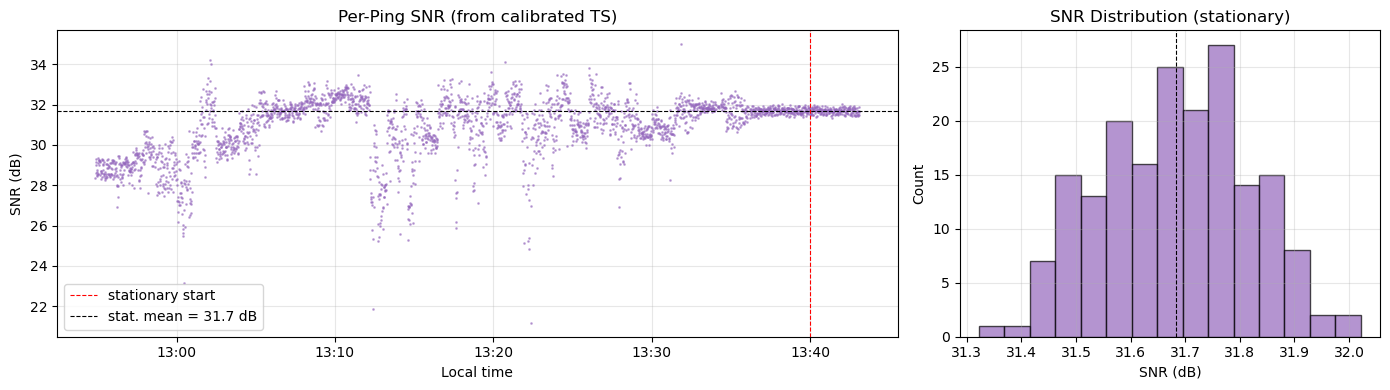

In [15]:
# Compute SNR from echopype's calibrated TS values (already correct at ~-40 dB)
# Use a noise gate between the target and the floor (2.0–2.5 m) for cleaner estimate
snr_noise_band = [2.0, 2.5]  # between sphere (~1.5m) and floor (~3m)

j0n_snr = np.searchsorted(r_ax, snr_noise_band[0])
j1n_snr = np.searchsorted(r_ax, snr_noise_band[1], side='right')
j0t_snr = np.searchsorted(r_ax, target_band[0])
j1t_snr = np.searchsorted(r_ax, target_band[1], side='right')

# Per-ping: peak TS in target gate vs mean TS in noise gate (both from echopype)
ts_peak_all  = np.nanmax(TS[:, j0t_snr:j1t_snr], axis=1)

# Mean noise TS per ping (average in linear domain)
noise_linear = 10 ** (TS[:, j0n_snr:j1n_snr] / 10)
ts_noise_all = 10 * np.log10(np.nanmean(noise_linear, axis=1))

snr_all  = ts_peak_all - ts_noise_all
snr_stat = snr_all[stat_mask]

print(f'SNR noise gate: {snr_noise_band[0]:.1f} – {snr_noise_band[1]:.1f} m')
print(f'SNR (all pings)  — mean: {np.nanmean(snr_all):.1f} dB,  std: {np.nanstd(snr_all):.2f} dB')
print(f'SNR (stationary) — mean: {np.nanmean(snr_stat):.1f} dB,  std: {np.nanstd(snr_stat):.2f} dB')

fig, (ax_ts, ax_hist) = plt.subplots(1, 2, figsize=(14, 4),
                                      gridspec_kw={'width_ratios': [2, 1]})

ax_ts.plot(local_times, snr_all, '.', markersize=2, alpha=0.5, color='#9467bd')
ax_ts.axvline(local_stat[0], color='r', ls='--', lw=0.8, label='stationary start')
ax_ts.axhline(np.nanmean(snr_stat), color='k', ls='--', lw=0.8,
              label=f'stat. mean = {np.nanmean(snr_stat):.1f} dB')
ax_ts.set_xlabel('Local time')
ax_ts.set_ylabel('SNR (dB)')
ax_ts.set_title('Per-Ping SNR (from calibrated TS)')
ax_ts.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_ts.legend()
ax_ts.grid(True, alpha=0.3)

ax_hist.hist(snr_stat[~np.isnan(snr_stat)], bins=15, color='#9467bd',
             edgecolor='k', alpha=0.7)
ax_hist.axvline(np.nanmean(snr_stat), color='k', ls='--', lw=0.8)
ax_hist.set_xlabel('SNR (dB)')
ax_hist.set_ylabel('Count')
ax_hist.set_title('SNR Distribution (stationary)')
ax_hist.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()